# Neural Network Classification with PyTorch

***Info time

`💡 Feedforward Propagation` - the flow of information occurs in the forward direction. The input is used to calculate some intermediate function in the hidden layer, which is then used to calculate an output. 

- In the feedforward propagation, the Activation Function is a mathematical “gate” in between the input feeding the current neuron and its output going to the next layer. 

`💡 Backpropagation` - the weights of the network connections are repeatedly adjusted to minimize the difference between the actual output vector of the net and the desired output vector.

- To put it simply—backpropagation aims to minimize the cost function by adjusting the network’s weights and biases. The cost function gradients determine the level of adjustment with respect to parameters like activation function, weights, bias, etc.

Perfect Resource: https://www.v7labs.com/blog/neural-networks-activation-functions#h1

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [4]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [38]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

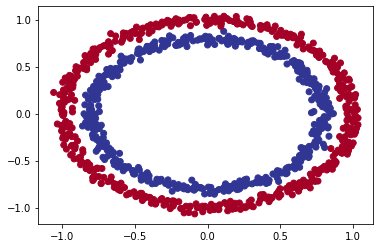

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu);

> **Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.



### Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train test splits

In [9]:
# Turn data into tensors
import torch

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [12]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [13]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [15]:
n_samples

1000

## Building a model

We want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by suıbclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic mode, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass nn.Module)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to our target device

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)
  
  # 3. Define a forward() that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x->layer_1, layer_1->layer_2, layer_2->output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cpu'

In [19]:
next(model_0.parameters()).device

device(type='cpu')

In [20]:
# Let's replicate the model above using nn.Sequential()
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.6026, -0.0869],
                      [-0.5014,  0.2861],
                      [ 0.6546,  0.0134],
                      [-0.6417,  0.2752],
                      [-0.5289,  0.4309]])),
             ('layer_1.bias',
              tensor([-0.4019,  0.5159, -0.5812, -0.4420,  0.5507])),
             ('layer_2.weight',
              tensor([[-0.2094, -0.1670,  0.0161,  0.1440, -0.3985]])),
             ('layer_2.bias', tensor([0.1164]))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[-0.4154],
        [-0.3279],
        [-0.3654],
        [-0.4307],
        [ 0.0784],
        [ 0.1284],
        [ 0.0232],
        [ 0.1312],
        [-0.3842],
        [-0.3171]])
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

Which loss function or optimizer should you use?

For example, for regression you might want MAE or MSE (mean absoule error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy

As a remainder, the loss function measures how wrong your models predictions are.

For optimizers, two of the most common are SGD and Adam

- For the loss function we're going to use `torch.nn.BCEWithLogitsLoss` - binary cross entropy (BCE) 

> `Logit:` In context of deep learning the logits layer means the layer that feeds in to softmax (or other such normalization). The output of the softmax are the probabilities for the classification task and its input is logits layer. The logits layer typically produces values from -infinity to +infinity and the softmax layer transforms it to values from 0 to 1.

In [23]:
 # Setup the loss function
 # loss_fn = nn.BCELoss() #BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
 loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

 optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

In [24]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train model

Training loop:

- Forward pass
- Calculate the loss
- Optimizer zero grad
- Loss backwards (backpropation)
- Optimizer (gradient descent)

from torch.nn.modules import activation
### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw `logits`

We can convert these `logits` into prediction probabilities by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert the model's prediction probabilities to **prediction_labels** by either rounding them or taking the `argmax()`

In [25]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4154],
        [-0.3279],
        [-0.3654],
        [-0.4307],
        [ 0.0784]])

Logits are the raw outputs of our model without being passed to any activation function

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3976],
        [0.4188],
        [0.4097],
        [0.3939],
        [0.5196]])

In [28]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full logits -> pred_probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

print(f"y_preds: {y_preds}")

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True])
y_preds: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]])


tensor([0., 0., 0., 0., 1.])

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building a trining and a test loop

In [36]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evalutaion loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits into pred probs into pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) #nn.BCELoss exptects prediction probabilitiees as input
  train_loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss exptects raw logits as input

  train_acc = accuracy_fn(y_true = y_train,
                    y_pred = y_preds)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation) -> calculates the gradients wrt all of the parameters in the model
  train_loss.backward()
  
  # Optimizer step (gradient descent) -> updates the parametersnto reduce the gradients
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    # Print out
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.70436, Train Acc: 48.12% | Test Loss: 0.70326, Test Acc: 46.00%
Epoch: 10 | Train Loss: 0.69841, Train Acc: 50.00% | Test Loss: 0.69780, Test Acc: 45.50%
Epoch: 20 | Train Loss: 0.69611, Train Acc: 50.50% | Test Loss: 0.69565, Test Acc: 45.50%
Epoch: 30 | Train Loss: 0.69502, Train Acc: 50.38% | Test Loss: 0.69461, Test Acc: 45.50%
Epoch: 40 | Train Loss: 0.69441, Train Acc: 49.88% | Test Loss: 0.69403, Test Acc: 49.00%
Epoch: 50 | Train Loss: 0.69403, Train Acc: 50.50% | Test Loss: 0.69367, Test Acc: 49.50%
Epoch: 60 | Train Loss: 0.69378, Train Acc: 50.25% | Test Loss: 0.69344, Test Acc: 50.50%
Epoch: 70 | Train Loss: 0.69361, Train Acc: 50.12% | Test Loss: 0.69329, Test Acc: 50.00%
Epoch: 80 | Train Loss: 0.69349, Train Acc: 50.50% | Test Loss: 0.69320, Test Acc: 50.50%
Epoch: 90 | Train Loss: 0.69340, Train Acc: 50.50% | Test Loss: 0.69315, Test Acc: 51.00%


## Make predictions and evaluate the model

In [43]:
import requests
from pathlib import Path

# Download helper functions from the Repo (if not downloaded)
if Path("helper_functions.py").is_file():
  print("Already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

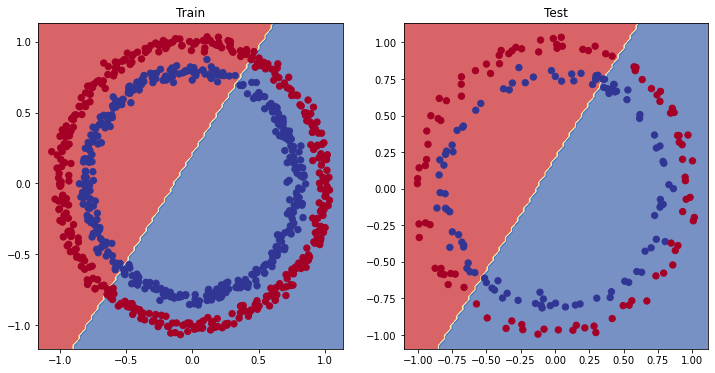

In [44]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model's perspective)

- Add more layers
- Add more hidden units
- Increase the number of epochs
- Change the activation functions
- Change the optimization function
- Change the learning rate
- Change the loss function

> These options are all values we can change, so they are referred as **hyperparameters**

In [58]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
      # z = self.layer_1(x)
      # z = self.layer_2(z)
      # z = self.layer_3(z)
      # return z
      return self.layer_2(self.layer_1(x))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [59]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.3891,  0.3533],
                      [-0.3664, -0.4772],
                      [-0.2258,  0.1484],
                      [ 0.3640, -0.2746],
                      [-0.4162,  0.0954],
                      [-0.4168, -0.4604],
                      [ 0.3686, -0.1188],
                      [ 0.6461,  0.6879],
                      [ 0.2115,  0.2434],
                      [ 0.1628,  0.0111]])),
             ('layer_1.bias',
              tensor([-0.0514,  0.0097,  0.2641,  0.6574, -0.1833, -0.2989, -0.1712, -0.3416,
                       0.1202,  0.5278])),
             ('layer_2.weight',
              tensor([[ 0.2473,  0.1452, -0.2327, -0.1697, -0.0695, -0.0583,  0.0260, -0.2903,
                        0.0984, -0.2412],
                      [-0.2001, -0.2629,  0.2755, -0.2994,  0.2386, -0.0106, -0.0368,  0.1978,
                       -0.0292,  0.1983],
                      [ 0.2286, -0.2746,  0.1217,  0.0597,  0.0680,  0.0462,  0.0865, 

In [60]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)

epochs=200

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2 Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)